**Chapter 13 – Processing Sequences Using RNNs and CNNs**

_This notebook contains all the sample code and solutions to the exercises in chapter 13._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-mlp/blob/main/13_processing_sequences_using_rnns_and_cnns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-mlp/blob/main/13_processing_sequences_using_rnns_and_cnns.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

This project requires Python 3.10 or above:

In [1]:
import sys

assert sys.version_info >= (3, 10)

Are we using Colab or Kaggle?

In [2]:
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

If using Colab, the TorchMetrics library is not pre-installed so we must install it manually:

In [3]:
if IS_COLAB:
    %pip install -q torchmetrics

We also need PyTorch ≥ 2.6.0:

In [4]:
from packaging.version import Version
import torch

assert Version(torch.__version__) >= Version("2.6.0")

This chapter can be very slow without a hardware accelerator, so if we can find one, let's use it:

In [5]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

device

'cuda'

Let's issue a warning if there's no hardware accelerator available:

In [6]:
if device == "cpu":
    print("Neural nets can be very slow without a hardware accelerator.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

As we did in earlier chapters, let's define the default font sizes to make the figures prettier:

In [7]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# Training RNNs

## Forecasting a Time Series

Let's download the ridership data from the ageron/data project. It originally comes from Chicago's Transit Authority, and was downloaded from the [Chicago's Data Portal](https://homl.info/ridership).

In [8]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def download_and_extract_ridership_data():
    tarball_path = Path("datasets/ridership.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/ridership.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets", filter="data")

download_and_extract_ridership_data()

Now let's clean up the data a bit:

In [9]:
import pandas as pd
from pathlib import Path

path = Path("datasets/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]  # shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # no need for total, it's just bus + rail
df = df.drop_duplicates()  # remove duplicated months (2011-10 and 2014-07)

In [10]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


Let's look at the first few months of 2019 (note that Pandas treats the range boundaries as inclusive):

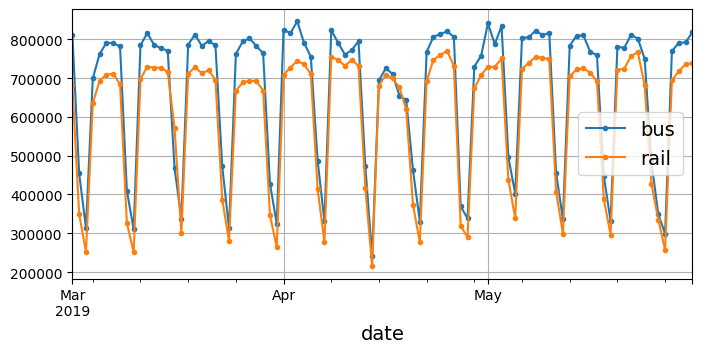

In [11]:
import matplotlib.pyplot as plt

df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))
plt.show()

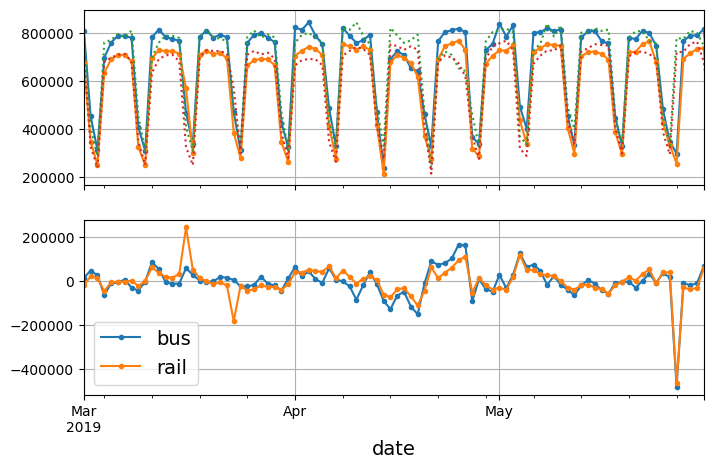

In [12]:
diff_7 = df[["bus", "rail"]].diff(7)["2019-03":"2019-05"]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
df.plot(ax=axs[0], legend=False, marker=".")  # original time series
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")  # lagged
diff_7.plot(ax=axs[1], grid=True, marker=".")  # 7-day difference time series
axs[0].set_ylim([170_000, 900_000])  # extra code – beautifies the plot

plt.show()

In [13]:
list(df.loc["2019-05-25":"2019-05-27"]["day_type"])

['A', 'U', 'U']

Mean absolute error (MAE), also called mean absolute deviation (MAD):

In [14]:
diff_7.abs().mean()

,0
bus,43915.608696
rail,42143.271739


Mean absolute percentage error (MAPE):

In [15]:
targets = df[["bus", "rail"]]["2019-03":"2019-05"]
(diff_7 / targets).abs().mean()

,0
bus,0.082938
rail,0.089948


Now let's look at the yearly seasonality and the long-term trends:

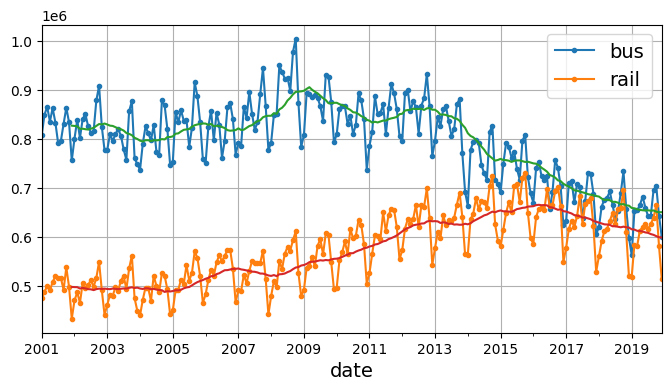

In [16]:
period = slice("2001", "2019")
df_monthly = df.select_dtypes(include="number").resample('ME').mean()
rolling_average_12_months = df_monthly.loc[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(8, 4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
plt.show()

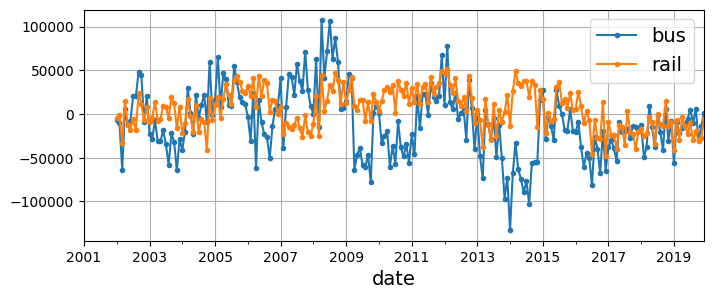

In [17]:
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(8, 3))
plt.show()

## The ARMA Model Family

If running on Colab or Kaggle, install the statsmodels library:

In [18]:
if IS_COLAB:
    %pip install -q -U statsmodels

In [19]:
from statsmodels.tsa.arima.model import ARIMA

origin, today = "2019-01-01", "2019-05-31"
rail_series = df.loc[origin:today]["rail"].asfreq("D")
model = ARIMA(rail_series,
              order=(1, 0, 0),
              seasonal_order=(0, 1, 1, 7))
model = model.fit()
y_pred = model.forecast()  # returns 427,758.6

In [20]:
y_pred.iloc[0]  # ARIMA forecast

np.float64(427758.6262875742)

In [21]:
df["rail"].loc["2019-06-01"]  # target value

np.int64(379044)

In [22]:
df["rail"].loc["2019-05-25"]  # naive forecast (value from one week earlier)

np.int64(426932)

In [23]:
origin, start_date, end_date = "2019-01-01", "2019-03-01", "2019-05-31"
time_period = pd.date_range(start_date, end_date)
rail_series = df.loc[origin:end_date]["rail"].asfreq("D")
y_preds = []
for today in time_period.shift(-1):
    model = ARIMA(rail_series[origin:today],  # train on data up to "today"
                  order=(1, 0, 0),
                  seasonal_order=(0, 1, 1, 7))
    model = model.fit()  # note that we retrain the model every day!
    y_pred = model.forecast().iloc[0]
    y_preds.append(y_pred)

y_preds = pd.Series(y_preds, index=time_period)
mae = (y_preds - rail_series[time_period]).abs().mean()  # returns 32,040.7

In [24]:
mae

np.float64(32040.72009292839)

/tmp/ipython-input-2292568549.py:4: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax.plot(y_preds, color="r", marker=".", label="SARIMA Forecasts")


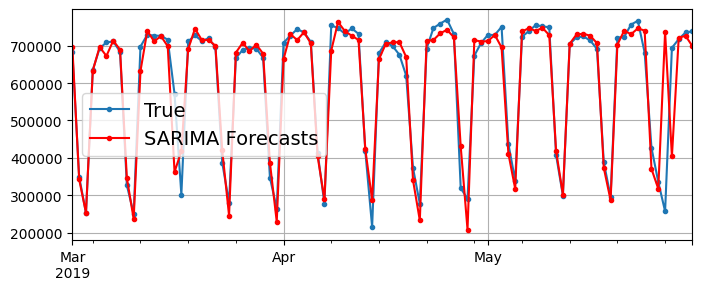

In [25]:
# extra code – displays the SARIMA forecasts
fig, ax = plt.subplots(figsize=(8, 3))
rail_series.loc[time_period].plot(label="True", ax=ax, marker=".", grid=True)
ax.plot(y_preds, color="r", marker=".", label="SARIMA Forecasts")
plt.legend()
plt.show()

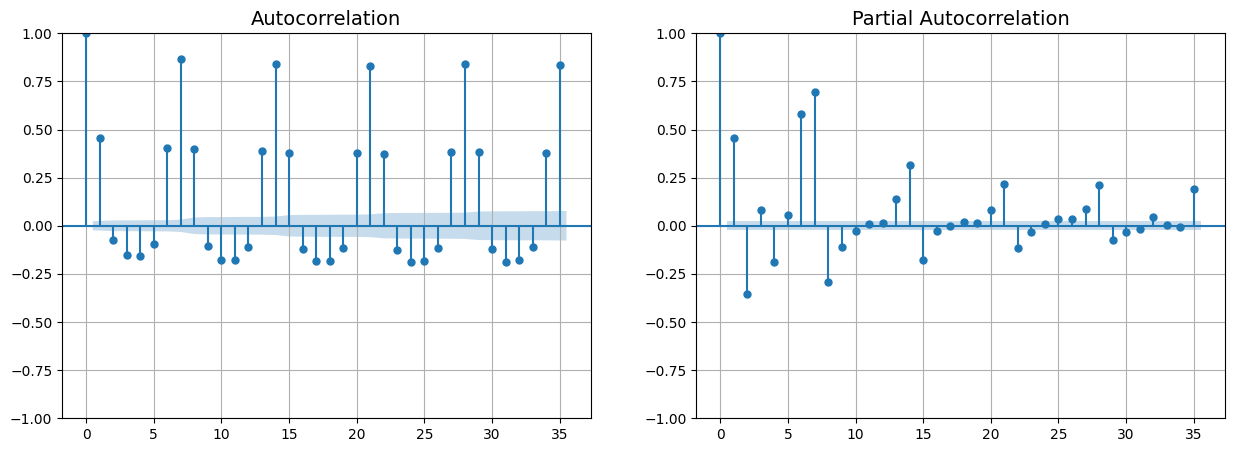

In [26]:
# extra code – shows how to plot the Autocorrelation Function (ACF) and the
#              Partial Autocorrelation Function (PACF)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plot_acf(df[period]["rail"], ax=axs[0], lags=35)
axs[0].grid()
plot_pacf(df[period]["rail"], ax=axs[1], lags=35, method="ywm")
axs[1].grid()
plt.show()

## Preparing the Data for Machine Learning Models

In [27]:
class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, series, window_length):
        self.series = series
        self.window_length = window_length

    def __len__(self):
        return len(self.series) - self.window_length

    def __getitem__(self, idx):
        if idx >= len(self):
            raise IndexError("dataset index out of range")
        end = idx + self.window_length  # 1st index after window
        window = self.series[idx : end]
        target = self.series[end]
        return window, target

In [28]:
my_series = torch.tensor([[0], [1], [2], [3], [4], [5]])
my_dataset = TimeSeriesDataset(my_series, window_length=3)
for window, target in my_dataset:
    print("Window:", window, " Target:", target)

Window: tensor([[0],
        [1],
        [2]])  Target: tensor([3])
Window: tensor([[1],
        [2],
        [3]])  Target: tensor([4])
Window: tensor([[2],
        [3],
        [4]])  Target: tensor([5])


In [29]:
from torch.utils.data import DataLoader
torch.manual_seed(0)
my_loader = DataLoader(my_dataset, batch_size=2, shuffle=True)
for X, y in my_loader:
    print("X:", X, " y:", y)

X: tensor([[[0],
         [1],
         [2]],

        [[2],
         [3],
         [4]]])  y: tensor([[3],
        [5]])
X: tensor([[[1],
         [2],
         [3]]])  y: tensor([[4]])


Before we continue looking at the data, let's split the time series into three periods, for training, validation and testing. We won't look at the test data for now:

In [30]:
rail_train = torch.FloatTensor(df[["rail"]]["2016-01":"2018-12"].values / 1e6)
rail_valid = torch.FloatTensor(df[["rail"]]["2019-01":"2019-05"].values / 1e6)
rail_test = torch.FloatTensor(df[["rail"]]["2019-06":].values / 1e6)

In [31]:
window_length = 56
train_set = TimeSeriesDataset(rail_train, window_length)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
valid_set = TimeSeriesDataset(rail_valid, window_length)
valid_loader = DataLoader(valid_set, batch_size=32)
test_set = TimeSeriesDataset(rail_test, window_length)
test_loader = DataLoader(test_set, batch_size=32)

In [32]:
import torchmetrics

def evaluate_tm(model, data_loader, metric):
    model.eval()
    metric.reset()
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            metric.update(y_pred, y_batch)
    return metric.compute()

def train(model, optimizer, loss_fn, metric, train_loader, valid_loader,
          n_epochs, patience=10, factor=0.1):
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=patience, factor=factor)
    history = {"train_losses": [], "train_metrics": [], "valid_metrics": []}
    for epoch in range(n_epochs):
        total_loss = 0.0
        metric.reset()
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            metric.update(y_pred, y_batch)
        history["train_losses"].append(total_loss / len(train_loader))
        history["train_metrics"].append(metric.compute().item())
        val_metric = evaluate_tm(model, valid_loader, metric).item()
        history["valid_metrics"].append(val_metric)
        scheduler.step(val_metric)
        print(f"Epoch {epoch + 1}/{n_epochs}, "
              f"train loss: {history['train_losses'][-1]:.4f}, "
              f"train metric: {history['train_metrics'][-1]:.4f}, "
              f"valid metric: {history['valid_metrics'][-1]:.4f}")
    return history

In [33]:
import torch.nn as nn
import torchmetrics

torch.manual_seed(42)
model = nn.Sequential(nn.Flatten(), nn.Linear(window_length, 1)).to(device)
loss_fn = nn.HuberLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
metric = torchmetrics.MeanAbsoluteError().to(device)

history = train(model, optimizer, loss_fn, metric, train_loader,
                valid_loader, n_epochs=50)

Epoch 1/50, train loss: 0.0154, train metric: 0.1458, valid metric: 0.1235
Epoch 2/50, train loss: 0.0100, train metric: 0.1117, valid metric: 0.0996
Epoch 3/50, train loss: 0.0075, train metric: 0.0933, valid metric: 0.0795
Epoch 4/50, train loss: 0.0063, train metric: 0.0816, valid metric: 0.0668
Epoch 5/50, train loss: 0.0056, train metric: 0.0741, valid metric: 0.0609
Epoch 6/50, train loss: 0.0053, train metric: 0.0697, valid metric: 0.0550
Epoch 7/50, train loss: 0.0049, train metric: 0.0663, valid metric: 0.0545
Epoch 8/50, train loss: 0.0047, train metric: 0.0636, valid metric: 0.0493
Epoch 9/50, train loss: 0.0045, train metric: 0.0617, valid metric: 0.0457
Epoch 10/50, train loss: 0.0045, train metric: 0.0615, valid metric: 0.0437
Epoch 11/50, train loss: 0.0043, train metric: 0.0586, valid metric: 0.0453
Epoch 12/50, train loss: 0.0042, train metric: 0.0577, valid metric: 0.0420
Epoch 13/50, train loss: 0.0042, train metric: 0.0576, valid metric: 0.0403
Epoch 14/50, train lo

In [34]:
evaluate_tm(model, valid_loader, metric).item() * 1e6

37725.720554590225

## Using a Simple RNN

In [35]:
class SimpleRnnModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.memory_cell = nn.Sequential(
            nn.Linear(input_size + hidden_size, hidden_size),
            nn.Tanh()
        )
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        batch_size, window_length, dimensionality = X.shape
        X_time_first = X.transpose(0, 1)
        H = torch.zeros(batch_size, self.hidden_size, device=X.device)
        for X_t in X_time_first:
            XH = torch.cat((X_t, H), dim=1)
            H = self.memory_cell(XH)
        return self.output(H)

torch.manual_seed(42)
model = SimpleRnnModel(input_size=1, hidden_size=32, output_size=1).to(device)

In [36]:
# extra code – defines a utility function we'll reuse several time

def fit_and_evaluate(model, train_loader, valid_loader, lr, n_epochs=50,
                     patience=20, factor=0.1):
    loss_fn = nn.HuberLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.95)
    metric = torchmetrics.MeanAbsoluteError().to(device)
    history = train(model, optimizer, loss_fn, metric,
                    train_loader, valid_loader, n_epochs=n_epochs,
                    patience=patience, factor=factor)
    return min(history["valid_metrics"]) * 1e6

In [37]:
torch.manual_seed(42)
univar_model = SimpleRnnModel(input_size=1, hidden_size=32, output_size=1)
univar_model = univar_model.to(device)
fit_and_evaluate(univar_model, train_loader, valid_loader, lr=0.05, n_epochs=50)

Epoch 1/50, train loss: 0.0523, train metric: 0.2600, valid metric: 0.2126
Epoch 2/50, train loss: 0.0174, train metric: 0.1542, valid metric: 0.1167
Epoch 3/50, train loss: 0.0135, train metric: 0.1421, valid metric: 0.1166
Epoch 4/50, train loss: 0.0106, train metric: 0.1212, valid metric: 0.1054
Epoch 5/50, train loss: 0.0075, train metric: 0.0968, valid metric: 0.0914
Epoch 6/50, train loss: 0.0060, train metric: 0.0831, valid metric: 0.0759
Epoch 7/50, train loss: 0.0055, train metric: 0.0776, valid metric: 0.0749
Epoch 8/50, train loss: 0.0051, train metric: 0.0748, valid metric: 0.0683
Epoch 9/50, train loss: 0.0047, train metric: 0.0710, valid metric: 0.0615
Epoch 10/50, train loss: 0.0047, train metric: 0.0706, valid metric: 0.0629
Epoch 11/50, train loss: 0.0047, train metric: 0.0699, valid metric: 0.0652
Epoch 12/50, train loss: 0.0046, train metric: 0.0696, valid metric: 0.0576
Epoch 13/50, train loss: 0.0045, train metric: 0.0689, valid metric: 0.0733
Epoch 14/50, train lo

30511.004850268364

In [38]:
class SimpleRnnModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        outputs, last_state = self.rnn(X)
        return self.output(outputs[:, -1])

In [39]:
torch.manual_seed(42)
univar_model = SimpleRnnModel(input_size=1, hidden_size=32, output_size=1)
univar_model = univar_model.to(device)
fit_and_evaluate(univar_model, train_loader, valid_loader, lr=0.05, n_epochs=50)

Epoch 1/50, train loss: 0.0487, train metric: 0.2535, valid metric: 0.1329
Epoch 2/50, train loss: 0.0181, train metric: 0.1523, valid metric: 0.1268
Epoch 3/50, train loss: 0.0137, train metric: 0.1459, valid metric: 0.1377
Epoch 4/50, train loss: 0.0122, train metric: 0.1348, valid metric: 0.1184
Epoch 5/50, train loss: 0.0115, train metric: 0.1279, valid metric: 0.1255
Epoch 6/50, train loss: 0.0105, train metric: 0.1231, valid metric: 0.1130
Epoch 7/50, train loss: 0.0090, train metric: 0.1127, valid metric: 0.1018
Epoch 8/50, train loss: 0.0064, train metric: 0.0885, valid metric: 0.0781
Epoch 9/50, train loss: 0.0055, train metric: 0.0792, valid metric: 0.0682
Epoch 10/50, train loss: 0.0048, train metric: 0.0727, valid metric: 0.0662
Epoch 11/50, train loss: 0.0044, train metric: 0.0683, valid metric: 0.0585
Epoch 12/50, train loss: 0.0043, train metric: 0.0675, valid metric: 0.0618
Epoch 13/50, train loss: 0.0043, train metric: 0.0662, valid metric: 0.0691
Epoch 14/50, train lo

30659.500509500504

## Deep RNNs

In [40]:
class DeepRnnModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=3, batch_first=True)
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        outputs, last_state = self.rnn(X)
        return self.output(outputs[:, -1])

Rather than hard-code the number of layers, let's add a `num_layers` argument:

In [41]:
class DeepRnnModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers,
                          batch_first=True)
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        outputs, last_state = self.rnn(X)
        return self.output(outputs[:, -1])

In [42]:
torch.manual_seed(42)
deep_model = DeepRnnModel(
    input_size=1, hidden_size=32, output_size=1, num_layers=3).to(device)
fit_and_evaluate(deep_model, train_loader, valid_loader, lr=0.07, n_epochs=50)

Epoch 1/50, train loss: 0.0632, train metric: 0.2830, valid metric: 0.2212
Epoch 2/50, train loss: 0.0189, train metric: 0.1573, valid metric: 0.0953
Epoch 3/50, train loss: 0.0083, train metric: 0.0964, valid metric: 0.1045
Epoch 4/50, train loss: 0.0066, train metric: 0.0868, valid metric: 0.0622
Epoch 5/50, train loss: 0.0053, train metric: 0.0738, valid metric: 0.0715
Epoch 6/50, train loss: 0.0051, train metric: 0.0727, valid metric: 0.0686
Epoch 7/50, train loss: 0.0052, train metric: 0.0741, valid metric: 0.0553
Epoch 8/50, train loss: 0.0057, train metric: 0.0791, valid metric: 0.0970
Epoch 9/50, train loss: 0.0046, train metric: 0.0666, valid metric: 0.0672
Epoch 10/50, train loss: 0.0044, train metric: 0.0640, valid metric: 0.0462
Epoch 11/50, train loss: 0.0039, train metric: 0.0588, valid metric: 0.0397
Epoch 12/50, train loss: 0.0037, train metric: 0.0582, valid metric: 0.0540
Epoch 13/50, train loss: 0.0035, train metric: 0.0536, valid metric: 0.0448
Epoch 14/50, train lo

29279.254376888275

## Multivariate time series

In [43]:
df_mulvar = df[["rail", "bus"]] / 1e6  # use both rail & bus series as input
df_mulvar["next_day_type"] = df["day_type"].shift(-1)  # we know tomorrow's type
df_mulvar = pd.get_dummies(df_mulvar, dtype=float)  # one-hot encode day type

In [44]:
mulvar_train = torch.FloatTensor(df_mulvar["2016-01":"2018-12"].values)
mulvar_valid = torch.FloatTensor(df_mulvar["2019-01":"2019-05"].values)
mulvar_test = torch.FloatTensor(df_mulvar["2019-06":].values)

In [45]:
class MulvarTimeSeriesDataset(TimeSeriesDataset):
    def __getitem__(self, idx):
        window, target = super().__getitem__(idx)
        return window, target[:1]

In [46]:
window_length = 56
mulvar_train_set = MulvarTimeSeriesDataset(mulvar_train, window_length)
mulvar_train_loader = DataLoader(mulvar_train_set, batch_size=32, shuffle=True)
mulvar_valid_set = MulvarTimeSeriesDataset(mulvar_valid, window_length)
mulvar_valid_loader = DataLoader(mulvar_valid_set, batch_size=32)
mulvar_test_set = MulvarTimeSeriesDataset(mulvar_test, window_length)
mulvar_test_loader = DataLoader(mulvar_test_set, batch_size=32)

In [47]:
torch.manual_seed(42)
mulvar_model = SimpleRnnModel(input_size=5, hidden_size=32, output_size=1)
mulvar_model = mulvar_model.to(device)

In [48]:
fit_and_evaluate(mulvar_model, mulvar_train_loader, mulvar_valid_loader, lr=0.05, n_epochs=50)

Epoch 1/50, train loss: 0.0652, train metric: 0.2960, valid metric: 0.0526
Epoch 2/50, train loss: 0.0076, train metric: 0.1007, valid metric: 0.0425
Epoch 3/50, train loss: 0.0028, train metric: 0.0558, valid metric: 0.0313
Epoch 4/50, train loss: 0.0018, train metric: 0.0410, valid metric: 0.0359
Epoch 5/50, train loss: 0.0017, train metric: 0.0383, valid metric: 0.0381
Epoch 6/50, train loss: 0.0015, train metric: 0.0368, valid metric: 0.0365
Epoch 7/50, train loss: 0.0014, train metric: 0.0356, valid metric: 0.0320
Epoch 8/50, train loss: 0.0014, train metric: 0.0364, valid metric: 0.0247
Epoch 9/50, train loss: 0.0014, train metric: 0.0356, valid metric: 0.0257
Epoch 10/50, train loss: 0.0015, train metric: 0.0380, valid metric: 0.0308
Epoch 11/50, train loss: 0.0013, train metric: 0.0339, valid metric: 0.0331
Epoch 12/50, train loss: 0.0012, train metric: 0.0328, valid metric: 0.0267
Epoch 13/50, train loss: 0.0012, train metric: 0.0332, valid metric: 0.0402
Epoch 14/50, train lo

23227.36755013466

We can forecast both the rail and bus riderships in one shot simply by changing `target[:1]` with `target[:2]`:

In [49]:
class MultaskTimeSeriesDataset(TimeSeriesDataset):
    def __getitem__(self, idx):
        window, target = super().__getitem__(idx)
        return window, target[:2]

window_length = 56
multask_train_set = MultaskTimeSeriesDataset(mulvar_train, window_length)
multask_train_loader = DataLoader(multask_train_set, batch_size=32, shuffle=True)
multask_valid_set = MultaskTimeSeriesDataset(mulvar_valid, window_length)
multask_valid_loader = DataLoader(multask_valid_set, batch_size=32)
multask_test_set = MultaskTimeSeriesDataset(mulvar_test, window_length)
multask_test_loader = DataLoader(multask_test_set, batch_size=32)

torch.manual_seed(42)
multask_model = SimpleRnnModel(input_size=5, hidden_size=32, output_size=2)
multask_model = multask_model.to(device)
fit_and_evaluate(multask_model, multask_train_loader, multask_valid_loader, lr=0.03, n_epochs=50)

Epoch 1/50, train loss: 0.0630, train metric: 0.2872, valid metric: 0.1379
Epoch 2/50, train loss: 0.0091, train metric: 0.1085, valid metric: 0.0680
Epoch 3/50, train loss: 0.0035, train metric: 0.0633, valid metric: 0.0294
Epoch 4/50, train loss: 0.0022, train metric: 0.0470, valid metric: 0.0329
Epoch 5/50, train loss: 0.0020, train metric: 0.0432, valid metric: 0.0313
Epoch 6/50, train loss: 0.0019, train metric: 0.0436, valid metric: 0.0394
Epoch 7/50, train loss: 0.0018, train metric: 0.0419, valid metric: 0.0392
Epoch 8/50, train loss: 0.0018, train metric: 0.0414, valid metric: 0.0311
Epoch 9/50, train loss: 0.0017, train metric: 0.0399, valid metric: 0.0307
Epoch 10/50, train loss: 0.0016, train metric: 0.0395, valid metric: 0.0337
Epoch 11/50, train loss: 0.0016, train metric: 0.0390, valid metric: 0.0321
Epoch 12/50, train loss: 0.0015, train metric: 0.0386, valid metric: 0.0322
Epoch 13/50, train loss: 0.0015, train metric: 0.0380, valid metric: 0.0307
Epoch 14/50, train lo

24694.617837667465

In [50]:
# extra code – evaluates the naive forecasts for bus
bus_naive = df_mulvar["2019-01":"2019-05"]["bus"].shift(7)[window_length:]
bus_target = df_mulvar["2019-01":"2019-05"]["bus"][window_length:]
(bus_target - bus_naive).abs().mean() * 1e6

np.float64(43441.63157894738)

In [51]:
# extra code – evaluates the multitask RNN's forecasts both rail and bus
multask_model.eval()
Y_pred_valid = [multask_model(X.to(device)) for X, _ in multask_valid_loader]
Y_pred_valid = torch.cat(Y_pred_valid, dim=0)
Y_valid = torch.cat([Y.to(device) for _, Y in multask_valid_loader], dim=0)
for idx, name in enumerate(["bus", "rail"]):
    mae = (Y_pred_valid[:, idx] - Y_valid[:, idx]).abs().mean()
    print(name, int(mae * 1e6))

bus 26178
rail 26441


## Forecasting Several Steps Ahead
**Note**: I fixed an error in the following code: we must unsqueeze the time dimension in `y_pred_one` (`dim=1`) instead of the batch dimension (`dim=0`). In this particular case, the result is the same because we're handling a single instance, but it would have failed we we had processed a batch.

In [52]:
univar_model.eval()
n_steps = 14
with torch.no_grad():
    X = rail_valid[:window_length].unsqueeze(dim=0).to(device)
    for step_ahead in range(n_steps):
        y_pred_one = univar_model(X)
        X = torch.cat([X, y_pred_one.unsqueeze(dim=1)], dim=1)

    Y_pred = X[0, -n_steps:, 0]

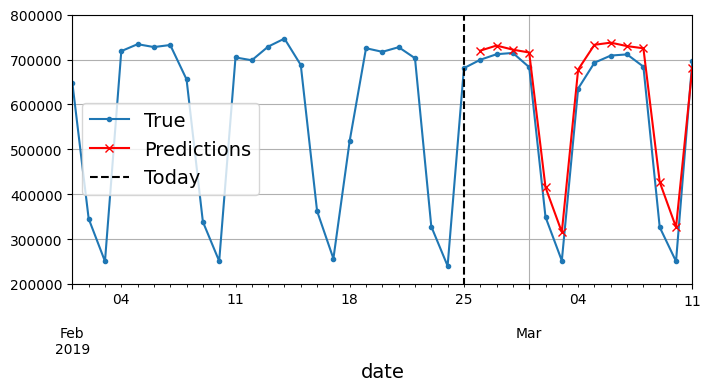

In [53]:
# extra code – generates Figure 13–11

# The forecasts start on 2019-02-26, as it is the 57th day of 2019, and they end
# on 2019-03-11. That's 14 days in total.
Y_pred_s = pd.Series(Y_pred.cpu() * 1e6,
                     index=pd.date_range("2019-02-26", "2019-03-11"))
fig, ax = plt.subplots(figsize=(8, 3.5))
df["2019-02-01":"2019-03-11"]["rail"].plot(label="True", marker=".", ax=ax)
Y_pred_s.plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines("2019-02-25", 0, 1e6, color="k", linestyle="--", label="Today")
ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")

plt.show()

Now let's create an RNN that predicts the rail ridership for the next 14 days all at once, using the multivariate time series we built earlier. For this, we first need to prepare datasets appropriately:

In [54]:
class ForecastAheadDataset(TimeSeriesDataset):
    def __len__(self):
        return len(self.series) - self.window_length - 14 + 1

    def __getitem__(self, idx):
        end = idx + self.window_length  # 1st index after window
        window = self.series[idx : end]
        target = self.series[end : end + 14, 0]  # 0 = rail ridership
        return window, target

In [55]:
window_length = 56
ahead_train_set = ForecastAheadDataset(mulvar_train, window_length)
ahead_train_loader = DataLoader(ahead_train_set, batch_size=32, shuffle=True)
ahead_valid_set = ForecastAheadDataset(mulvar_valid, window_length)
ahead_valid_loader = DataLoader(ahead_valid_set, batch_size=32)
ahead_test_set = ForecastAheadDataset(mulvar_test, window_length)
ahead_test_loader = DataLoader(ahead_test_set, batch_size=32)

In [56]:
torch.manual_seed(42)
ahead_model = SimpleRnnModel(input_size=5, hidden_size=32, output_size=14)
ahead_model = ahead_model.to(device)
fit_and_evaluate(ahead_model, ahead_train_loader, ahead_valid_loader, lr=0.05, n_epochs=50)

Epoch 1/50, train loss: 0.0725, train metric: 0.3051, valid metric: 0.1730
Epoch 2/50, train loss: 0.0164, train metric: 0.1480, valid metric: 0.1142
Epoch 3/50, train loss: 0.0099, train metric: 0.1133, valid metric: 0.0975
Epoch 4/50, train loss: 0.0076, train metric: 0.0946, valid metric: 0.0832
Epoch 5/50, train loss: 0.0066, train metric: 0.0846, valid metric: 0.0749
Epoch 6/50, train loss: 0.0060, train metric: 0.0783, valid metric: 0.0651
Epoch 7/50, train loss: 0.0053, train metric: 0.0728, valid metric: 0.0600
Epoch 8/50, train loss: 0.0052, train metric: 0.0685, valid metric: 0.0554
Epoch 9/50, train loss: 0.0047, train metric: 0.0663, valid metric: 0.0546
Epoch 10/50, train loss: 0.0044, train metric: 0.0633, valid metric: 0.0506
Epoch 11/50, train loss: 0.0043, train metric: 0.0619, valid metric: 0.0489
Epoch 12/50, train loss: 0.0042, train metric: 0.0604, valid metric: 0.0471
Epoch 13/50, train loss: 0.0042, train metric: 0.0598, valid metric: 0.0498
Epoch 14/50, train lo

32950.77010989189

In [57]:
ahead_model.eval()
with torch.no_grad():
    window = mulvar_valid[:window_length]  # shape [56, 5]
    X = window.unsqueeze(dim=0)            # shape [1, 56, 5]
    Y_pred = ahead_model(X.to(device))     # shape [1, 14]

## Forecasting Using a Sequence-to-Sequence Model

Now let's create an RNN that predicts the next 14 steps at each time step. That is, instead of just forecasting time steps 56 to 69 based on time steps 0 to 55, it will forecast time steps 1 to 14 at time step 0, then time steps 2 to 15 at time step 1, and so on, and finally it will forecast time steps 56 to 69 at the last time step. Notice that the model is causal: when it makes predictions at any time step, it can only see past time steps.

In [58]:
class Seq2SeqDataset(ForecastAheadDataset):
    def __getitem__(self, idx):
        end = idx + self.window_length  # 1st index after window
        window = self.series[idx : end]
        target_period = self.series[idx + 1 : end + 14, 0]
        target = target_period.unfold(dimension=0, size=14, step=1)
        return window, target

In [59]:
torch.tensor([0, 1, 2, 3, 4, 5]).unfold(dimension=0, size=4, step=1)

tensor([[0, 1, 2, 3],
        [1, 2, 3, 4],
        [2, 3, 4, 5]])

In [60]:
window_length = 56
seq_train_set = Seq2SeqDataset(mulvar_train, window_length)
seq_train_loader = DataLoader(seq_train_set, batch_size=32, shuffle=True)
seq_valid_set = Seq2SeqDataset(mulvar_valid, window_length)
seq_valid_loader = DataLoader(seq_valid_set, batch_size=32)
seq_test_set = Seq2SeqDataset(mulvar_test, window_length)
seq_test_loader = DataLoader(seq_test_set, batch_size=32)

In [61]:
class Seq2SeqRnnModel(SimpleRnnModel):
    def forward(self, X):
        outputs, last_state = self.rnn(X)
        return self.output(outputs)

Under the hood, the `Linear` module calls the `torch.matmul()` function, which supports multiplying arrays of more than 2D, for example:

In [62]:
torch.matmul(torch.randn(2, 3, 5, 7), torch.randn(2, 3, 7, 11)).shape

torch.Size([2, 3, 5, 11])

It also supports broadcasting:

In [63]:
torch.matmul(torch.randn(2, 3, 5, 7), torch.randn(7, 11)).shape

torch.Size([2, 3, 5, 11])

This is why the `Linear` module can be applied to 3D inputs: it is applied efficiently at each time step.

In [64]:
nn.Linear(32, 14)(torch.randn(10, 56, 32)).shape

torch.Size([10, 56, 14])

In [65]:
torch.manual_seed(42)
seq_model = Seq2SeqRnnModel(input_size=5, hidden_size=32, output_size=14)
seq_model = seq_model.to(device)
fit_and_evaluate(seq_model, seq_train_loader, seq_valid_loader, lr=1.0, n_epochs=65,
                 patience=5, factor=0.5)

Epoch 1/65, train loss: 0.0332, train metric: 0.1934, valid metric: 0.1210
Epoch 2/65, train loss: 0.0084, train metric: 0.0975, valid metric: 0.0756
Epoch 3/65, train loss: 0.0050, train metric: 0.0695, valid metric: 0.0662
Epoch 4/65, train loss: 0.0042, train metric: 0.0600, valid metric: 0.0495
Epoch 5/65, train loss: 0.0043, train metric: 0.0630, valid metric: 0.1052
Epoch 6/65, train loss: 0.0039, train metric: 0.0568, valid metric: 0.0552
Epoch 7/65, train loss: 0.0035, train metric: 0.0523, valid metric: 0.0655
Epoch 8/65, train loss: 0.0036, train metric: 0.0520, valid metric: 0.0565
Epoch 9/65, train loss: 0.0034, train metric: 0.0509, valid metric: 0.0485
Epoch 10/65, train loss: 0.0035, train metric: 0.0532, valid metric: 0.0536
Epoch 11/65, train loss: 0.0034, train metric: 0.0500, valid metric: 0.0506
Epoch 12/65, train loss: 0.0034, train metric: 0.0526, valid metric: 0.0473
Epoch 13/65, train loss: 0.0032, train metric: 0.0488, valid metric: 0.0636
Epoch 14/65, train lo

47337.66242861748

In [66]:
seq_model.eval()
with torch.no_grad():
    some_window = mulvar_valid[:window_length]  # shape [56, 5]
    X = some_window.unsqueeze(dim=0)            # shape [1, 56, 5]
    Y_preds = seq_model(X.to(device))           # shape [1, 56, 14]
    Y_pred = Y_preds[:, -1]                     # shape [1, 14]

In [67]:
with torch.no_grad():
    X = mulvar_valid.unsqueeze(dim=0).to(device)  # shape [1, 151, 5]
    Y_preds_valid = seq_model(X).cpu()            # shape [1, 151, 14]

for ahead in range(1, 14 + 1):
    y_preds = Y_preds_valid[0, window_length : -ahead, ahead - 1]
    y_true = rail_valid[window_length + ahead:, 0]
    mae = (y_preds - y_true).abs().mean() * 1e6
    print(f"MAE for +{ahead}:\t{mae:,.0f}")

MAE for +1:	23,689
MAE for +2:	35,101
MAE for +3:	37,545
MAE for +4:	39,053
MAE for +5:	39,728
MAE for +6:	40,121
MAE for +7:	39,105
MAE for +8:	39,569
MAE for +9:	39,459
MAE for +10:	39,747
MAE for +11:	40,008
MAE for +12:	38,468
MAE for +13:	37,255
MAE for +14:	35,862


In [68]:
# extra code: show that a Conv1d with kernel_size=1 is equivalent to
# a Linear layer when applied to a time series, if you permute the
# last two dimensions of the inputs and outputs.
torch.manual_seed(42)
with torch.no_grad():
    X = torch.randn(10, 56, 32)
    conv1d = nn.Conv1d(32, 14, kernel_size=1)
    linear = nn.Linear(32, 14)
    linear.weight.data = conv1d.weight.squeeze(dim=2)
    linear.bias.data = conv1d.bias
    result1 = conv1d(X.permute(0, 2, 1)).permute(0, 2, 1)
    result2 = linear(X)

torch.allclose(result1, result2, atol=1e-7)

True

# Deep RNNs with Layer Norm

In [69]:
class SimpleRnnModelWithLN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.memory_cell = nn.Sequential(
            nn.Linear(input_size + hidden_size, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.Tanh()
        )
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        batch_size, window_length, dimensionality = X.shape
        X_time_first = X.transpose(0, 1)
        H = torch.zeros(batch_size, self.hidden_size, device=X.device)
        for X_t in X_time_first:
            XH = torch.cat((X_t, H), dim=1)
            H = self.memory_cell(XH)
        return self.output(H)

In [70]:
torch.manual_seed(42)
rnn_with_ln_model = SimpleRnnModelWithLN(input_size=5, hidden_size=32, output_size=14)
rnn_with_ln_model = rnn_with_ln_model.to(device)
fit_and_evaluate(rnn_with_ln_model, ahead_train_loader, ahead_valid_loader,
                 lr=0.05, n_epochs=2)

Epoch 1/2, train loss: 0.0693, train metric: 0.2941, valid metric: 0.1618
Epoch 2/2, train loss: 0.0207, train metric: 0.1647, valid metric: 0.1438


143809.512257576

# LSTMs

In [71]:
class LstmModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        outputs, last_state = self.rnn(X)
        return self.output(outputs[:, -1])

In [72]:
torch.manual_seed(42)
lstm_model = LstmModel(input_size=5, hidden_size=32, output_size=14)
lstm_model = lstm_model.to(device)
fit_and_evaluate(lstm_model, ahead_train_loader, ahead_valid_loader,
                 lr=0.05, n_epochs=2)

Epoch 1/2, train loss: 0.0940, train metric: 0.3618, valid metric: 0.2087
Epoch 2/2, train loss: 0.0258, train metric: 0.1747, valid metric: 0.1717


171688.5268688202

In [73]:
class LstmModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.memory_cell = nn.LSTMCell(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        batch_size, window_length, dimensionality = X.shape
        X_time_first = X.transpose(0, 1)
        H = torch.zeros(batch_size, self.hidden_size, device=X.device)
        C = torch.zeros(batch_size, self.hidden_size, device=X.device)
        for X_t in X_time_first:
            H, C = self.memory_cell(X_t, (H, C))
        return self.output(H)

In [74]:
torch.manual_seed(42)
lstm_model = LstmModel(input_size=5, hidden_size=32, output_size=14)
lstm_model = lstm_model.to(device)
fit_and_evaluate(lstm_model, ahead_train_loader, ahead_valid_loader, lr=0.05, n_epochs=2)

Epoch 1/2, train loss: 0.0940, train metric: 0.3618, valid metric: 0.2087
Epoch 2/2, train loss: 0.0258, train metric: 0.1747, valid metric: 0.1717


171688.46726417542

# GRUs

In [75]:
class GruModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        outputs, last_state = self.rnn(X)
        return self.output(outputs[:, -1])

In [76]:
torch.manual_seed(42)
gru_model = GruModel(input_size=5, hidden_size=32, output_size=14)
gru_model = gru_model.to(device)
fit_and_evaluate(gru_model, ahead_train_loader, ahead_valid_loader,
                 lr=0.05, n_epochs=2)

Epoch 1/2, train loss: 0.0813, train metric: 0.3289, valid metric: 0.1561
Epoch 2/2, train loss: 0.0212, train metric: 0.1757, valid metric: 0.1410


141033.56003761292

In [77]:
class GruModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.memory_cell = nn.GRUCell(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        batch_size, window_length, dimensionality = X.shape
        X_time_first = X.transpose(0, 1)
        H = torch.zeros(batch_size, self.hidden_size, device=X.device)
        for X_t in X_time_first:
            H = self.memory_cell(X_t, H)
        return self.output(H)

In [78]:
torch.manual_seed(42)
gru_model = GruModel(input_size=5, hidden_size=32, output_size=14)
gru_model = gru_model.to(device)
fit_and_evaluate(gru_model, ahead_train_loader, ahead_valid_loader,
                 lr=0.05, n_epochs=2)

Epoch 1/2, train loss: 0.0813, train metric: 0.3289, valid metric: 0.1561
Epoch 2/2, train loss: 0.0212, train metric: 0.1757, valid metric: 0.1410


141033.3216190338

## Using One-Dimensional Convolutional Layers to Process Sequences

```
  |-----0-----||-----2----||-----4----||--...-||------52------||------54------|
         |-----1----||-----3----||-----5--...-51------||------53------|
X:  0  1  2  3  4  5  6  7  8  9 10 11 12 ...  104 105 106 107 108 109 110 111
Y:      from 4     6     8    10    12    ...      106     108     110     112
         to 17    19    21    23    25    ...      119     121     123     125
```

In [79]:
class DownsamplingModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.conv = nn.Conv1d(input_size, hidden_size, kernel_size=4, stride=2)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        Z = X.permute(0, 2, 1)  # treat time as a spatial dimension
        Z = self.conv(Z)
        Z = Z.permute(0, 2, 1)  # swap back time & features dimensions
        Z = torch.relu(Z)
        Z, _states = self.gru(Z)
        return self.linear(Z)

torch.manual_seed(42)
dseq_model = DownsamplingModel(input_size=1, hidden_size=32, output_size=14)
dseq_model = dseq_model.to(device)

In [80]:
class DownsampledDataset(Seq2SeqDataset):
    def __getitem__(self, idx):
        window, target = super().__getitem__(idx)
        return window, target[3::2]  # crop the first 3 targets and downsample

window_length = 112
dseq_train_set = DownsampledDataset(rail_train, window_length)
dseq_train_loader = DataLoader(dseq_train_set, batch_size=32, shuffle=True)
dseq_valid_set = DownsampledDataset(rail_valid, window_length)
dseq_valid_loader = DataLoader(dseq_valid_set, batch_size=32)
dseq_test_set = DownsampledDataset(rail_test, window_length)
dseq_test_loader = DataLoader(dseq_test_set, batch_size=32)

In [81]:
torch.manual_seed(42)
dseq_model = DownsamplingModel(input_size=1, hidden_size=32, output_size=14)
dseq_model = dseq_model.to(device)
fit_and_evaluate(dseq_model, dseq_train_loader, dseq_valid_loader,
                 lr=0.2, n_epochs=2)

Epoch 1/2, train loss: 0.0595, train metric: 0.2736, valid metric: 0.1971
Epoch 2/2, train loss: 0.0204, train metric: 0.1694, valid metric: 0.1572


157236.17374897003

## WaveNet

```
 ⋮
C2  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\...
   \  /  \  /  \  /  \  /  \  /  \  /  \     
     /    \      /    \      /    \          
C1  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\  /\ /...\
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 111
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 112
 /14 15 16 17 18 19 20 21 22  23 24 25 26 ... 125
```

Here's a simple implementation of a causal convolution:

In [82]:
import torch.nn.functional as F

class CausalConv1d(nn.Conv1d):
    def forward(self, X):
        padding = (self.kernel_size[0] - 1) * self.dilation[0]
        X = F.pad(X, (padding, 0))
        return super().forward(X)

Here's another common implementation, called the _chomp_ approach: we use regular padding (both left and right) then chop off the right part.

In [83]:
class CausalConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1, **kwargs):
        super().__init__()
        self.pad = (kernel_size - 1) * dilation
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=self.pad, dilation=dilation, **kwargs)

    def forward(self, x):
        out = self.conv(x)
        return out[:, :, :-self.pad] if self.pad > 0 else out

In [84]:
class WavenetModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        layers = []
        for dilation in (1, 2, 4, 8) * 2:
            conv = CausalConv1d(input_size, hidden_size, kernel_size=2,
                                dilation=dilation)
            layers += [conv, nn.ReLU()]
            input_size = hidden_size
        self.convs = nn.Sequential(*layers)
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        Z = X.permute(0, 2, 1)
        Z = self.convs(Z)
        Z = Z.permute(0, 2, 1)
        return self.output(Z)

torch.manual_seed(42)
wavenet_model = WavenetModel(input_size=5, hidden_size=32, output_size=14)
wavenet_model = wavenet_model.to(device)

In [85]:
fit_and_evaluate(wavenet_model, seq_train_loader, seq_valid_loader,
                 lr=0.1, n_epochs=150)

Epoch 1/150, train loss: 0.0847, train metric: 0.3390, valid metric: 0.1920
Epoch 2/150, train loss: 0.0191, train metric: 0.1731, valid metric: 0.1560
Epoch 3/150, train loss: 0.0167, train metric: 0.1527, valid metric: 0.1408
Epoch 4/150, train loss: 0.0162, train metric: 0.1594, valid metric: 0.1502
Epoch 5/150, train loss: 0.0162, train metric: 0.1577, valid metric: 0.1453
Epoch 6/150, train loss: 0.0161, train metric: 0.1576, valid metric: 0.1473
Epoch 7/150, train loss: 0.0162, train metric: 0.1580, valid metric: 0.1465
Epoch 8/150, train loss: 0.0162, train metric: 0.1583, valid metric: 0.1471
Epoch 9/150, train loss: 0.0161, train metric: 0.1577, valid metric: 0.1468
Epoch 10/150, train loss: 0.0161, train metric: 0.1577, valid metric: 0.1469
Epoch 11/150, train loss: 0.0162, train metric: 0.1586, valid metric: 0.1467
Epoch 12/150, train loss: 0.0162, train metric: 0.1570, valid metric: 0.1465
Epoch 13/150, train loss: 0.0161, train metric: 0.1585, valid metric: 0.1469
Epoch 14

140761.01779937744

In this chapter we explored the fundamentals of RNNs and used them to process sequences (specifically, time series). In the process we also learned about ARMA models, and we looked at other ways to process sequences, including CNNs. In the next chapter we will use RNNs for Natural Language Processing, and we will learn more about RNNs (bidirectional RNNs, stateful vs stateless RNNs, Encoder–Decoders, and Attention-augmented Encoder-Decoders).

# Exercise solutions

## Exercises 1. to 8.

1. Here are a few RNN applications:
    * For a sequence-to-sequence RNN: predicting the weather (or any other time series), machine translation (using an Encoder–Decoder architecture), video captioning, speech to text, music generation (or other sequence generation), identifying the chords of a song
    * For a sequence-to-vector RNN: classifying music samples by music genre, analyzing the sentiment of a book review, predicting what word an aphasic patient is thinking of based on readings from brain implants, predicting the probability that a user will want to watch a movie based on their watch history (this is one of many possible implementations of _collaborative filtering_ for a recommender system)
    * For a vector-to-sequence RNN: image captioning, creating a music playlist based on an embedding of the current artist, generating a melody based on a set of parameters, locating pedestrians in a picture (e.g., a video frame from a self-driving car's camera)
2. An RNN layer must have three-dimensional inputs: if you set `batch_first=True` when creating the RNN layer, the first dimension is the batch dimension (its size is the batch size), the second dimension represents the time (its size is the number of time steps), and the third dimension holds the inputs at each time step (its size is the number of input features per time step). For example, if you want to process a batch containing 5 time series of 10 time steps each, with 2 values per time step (e.g., the temperature and the wind speed), the shape will be [5, 10, 2]. The outputs are also three-dimensional, with the same first two dimensions, but the last dimension is equal to the number of neurons. For example, if an RNN layer with 32 neurons processes the batch we just discussed, the output will have a shape of [5, 10, 32]. If you set `batch_first=False` (which is the default), then the first two dimensions are swapped.
3. To build a deep sequence-to-sequence RNN in PyTorch, the simplest and most efficient option is to use the `nn.RNN`, `nn.LSTM`, or `nn.GRU` modules and set the `num_layers` hyperparameter to the desired number of layers. However, if you need more flexibility (e.g., to add dropout or layer norm between time steps), you must create a custom module and implement the recurrent loop manually. For this, you can use the `nn.RNNCell`, `nn.LSTMCell`, or `nn.GRUCell` modules and run them at each step, passing them both the inputs and the hidden states.
4. If you have a daily univariate time series, and you want to forecast the next seven days, the simplest RNN architecture you can use is a stack of RNN layers, using seven neurons in the output RNN layer. You can then train this model using random windows from the time series (e.g., sequences of 30 consecutive days as the inputs, and a vector containing the values of the next 7 days as the target). This is a sequence-to-vector RNN. Alternatively, you could use a sequence-to-sequence RNN. You can train this model using random windows from the time series, with sequences of the same length as the inputs as the targets. Each target sequence should have seven values per time step (e.g., for time step _t_, the target should be a vector containing the values at time steps _t_ + 1 to _t_ + 7).
5. The two main difficulties when training RNNs are unstable gradients (exploding or vanishing) and a very limited short-term memory. These problems both get worse when dealing with long sequences. To alleviate the unstable gradients problem, you can use a smaller learning rate, use a saturating activation function such as the hyperbolic tangent (which is the default), and possibly use gradient clipping, Layer Normalization, or dropout at each time step. To tackle the limited short-term memory problem, you can use `LSTM` or `GRU` layers (this also helps with the unstable gradients problem). That said, more recent architectures such as Transformers and State-Space Models (SSMs, see [Appendix E](https://ageron.github.io/)) have a much longer memory.
6. An LSTM cell's architecture looks complicated, but it's actually not too hard if you understand the underlying logic. The cell has a short-term state vector and a long-term state vector. At each time step, the inputs and the previous short-term state are fed to a simple RNN cell and three gates: the forget gate decides what to remove from the long-term state, the input gate decides which part of the output of the simple RNN cell should be added to the long-term state, and the output gate decides which part of the long-term state should be output at this time step (after going through the tanh activation function). The new short-term state is equal to the output of the cell. See Figure 13–12.
7. An RNN layer is fundamentally sequential: in order to compute the outputs at time step _t_, it has to first compute the outputs at all earlier time steps. This makes it impossible to parallelize (unless the RNN is fully linear, as in modern SSMs, see [Appendix E](https://homl.info/)). On the other hand, a 1D convolutional layer lends itself well to parallelization since it does not hold a state between time steps. In other words, it has no memory: the output at any time step can be computed based only on a small window of values from the inputs without having to know all the past values. Moreover, since a 1D convolutional layer is not recurrent, it suffers less from unstable gradients. One or more 1D convolutional layers can be useful in an RNN to efficiently preprocess the inputs, for example to reduce their temporal resolution (downsampling) and thereby help the RNN layers detect long-term patterns. In fact, it is possible to use only convolutional layers, for example by building a WaveNet architecture.
8. To classify videos based on their visual content, one possible architecture could be to take (say) one frame per second, then run every frame through the same convolutional neural network (e.g., a pretrained Xception model, possibly frozen if your dataset is not large), feed the sequence of outputs from the CNN to a sequence-to-vector RNN, and finally run its output through a softmax layer, giving you all the class probabilities. For training you would use cross entropy as the cost function. If you wanted to use the audio for classification as well, you could use a stack of strided 1D convolutional layers to reduce the temporal resolution from thousands of audio frames per second to just one per second (to match the number of images per second), and concatenate the output sequence to the inputs of the sequence-to-vector RNN (along the last dimension). However, transformers and SSMs are much better choices for video classification (see Chapters 15, 16, and [Appendix E](https://homl.info/)).

## Exercise 9 — Forecast Both Rail and Bus Ridership

Exercise: _Try to tweak the `Seq2SeqRnnModel` model to forecast both rail and bus ridership for the next 14 days. The model will now need to predict 28 values instead of 14._

Let's start by creating a dataset similar to `Seq2SeqDataset` but whose targets include both the rail and bus riderships, so they have a shape of [56, 2, 14] instead of [56, 14]:

In [86]:
class Seq2SeqRailBusDataset(torch.utils.data.Dataset):
    def __init__(self, series, window_length, forecast_ahead):
        self.series = series
        self.window_length = window_length
        self.forecast_ahead = forecast_ahead

    def __len__(self):
        return len(self.series) - self.window_length - self.forecast_ahead + 1

    def __getitem__(self, idx):
        if idx >= len(self):
            raise IndexError("dataset index out of range")
        end = idx + self.window_length  # 1st index after window
        window = self.series[idx : end]
        target_period = self.series[idx + 1 : end + self.forecast_ahead, :2]
        target = target_period.unfold(dimension=0, size=self.forecast_ahead,
                                      step=1)
        return window, target

Let's create the train, valid, and test sets, and their corresponding data loaders:

In [87]:
window_length = 56
forecast_ahead = 14
seq2seq_rb_train_set = Seq2SeqRailBusDataset(mulvar_train, window_length,
                                             forecast_ahead)
seq2seq_rb_train_loader = DataLoader(seq2seq_rb_train_set, batch_size=32,
                                     shuffle=True)
seq2seq_rb_valid_set = Seq2SeqRailBusDataset(mulvar_valid, window_length,
                                             forecast_ahead)
seq2seq_rb_valid_loader = DataLoader(seq2seq_rb_valid_set, batch_size=32)
seq2seq_rb_test_set = Seq2SeqRailBusDataset(mulvar_test, window_length,
                                            forecast_ahead)
seq2seq_rb_test_loader = DataLoader(seq2seq_rb_test_set, batch_size=32)

Let's create our model. We will base it on an LSTM:

In [88]:
class Seq2SeqRailBusModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_length, output_size):
        super().__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.output = nn.Linear(hidden_size, output_length * output_size)
        self.output_length = output_length
        self.output_size = output_size

    def forward(self, X):
        B, L, _ = X.shape
        outputs, last_state = self.rnn(X)
        preds = self.output(outputs)
        return preds.view(B, L, self.output_size, self.output_length)

And now let's train the model:

In [89]:
torch.manual_seed(42)
seq2seq_rb_model = Seq2SeqRailBusModel(input_size=5, hidden_size=32,
                                       output_length=14, output_size=2)
seq2seq_rb_model = seq2seq_rb_model.to(device)
fit_and_evaluate(seq2seq_rb_model, seq2seq_rb_train_loader,
                 seq2seq_rb_valid_loader, lr=1.0, n_epochs=65,
                 patience=5, factor=0.5)

Epoch 1/65, train loss: 0.0532, train metric: 0.2550, valid metric: 0.1607
Epoch 2/65, train loss: 0.0186, train metric: 0.1646, valid metric: 0.1447
Epoch 3/65, train loss: 0.0138, train metric: 0.1384, valid metric: 0.1273
Epoch 4/65, train loss: 0.0118, train metric: 0.1240, valid metric: 0.1172
Epoch 5/65, train loss: 0.0104, train metric: 0.1145, valid metric: 0.1104
Epoch 6/65, train loss: 0.0094, train metric: 0.1080, valid metric: 0.1075
Epoch 7/65, train loss: 0.0087, train metric: 0.1026, valid metric: 0.1046
Epoch 8/65, train loss: 0.0081, train metric: 0.0975, valid metric: 0.1002
Epoch 9/65, train loss: 0.0073, train metric: 0.0922, valid metric: 0.0937
Epoch 10/65, train loss: 0.0066, train metric: 0.0868, valid metric: 0.0866
Epoch 11/65, train loss: 0.0060, train metric: 0.0815, valid metric: 0.0815
Epoch 12/65, train loss: 0.0056, train metric: 0.0764, valid metric: 0.0738
Epoch 13/65, train loss: 0.0052, train metric: 0.0724, valid metric: 0.0712
Epoch 14/65, train lo

47222.3274409771

We can use the model like this:

In [90]:
seq2seq_rb_model.eval()
with torch.no_grad():
    some_window = mulvar_valid[:window_length]  # shape [56, 5]
    X = some_window.unsqueeze(dim=0)            # shape [1, 56, 5]
    Y_preds = seq2seq_rb_model(X.to(device))    # shape [1, 56, 2, 14]
    Y_pred = Y_preds[0, -1]                     # shape [2, 14]

Let's plot these predictions:

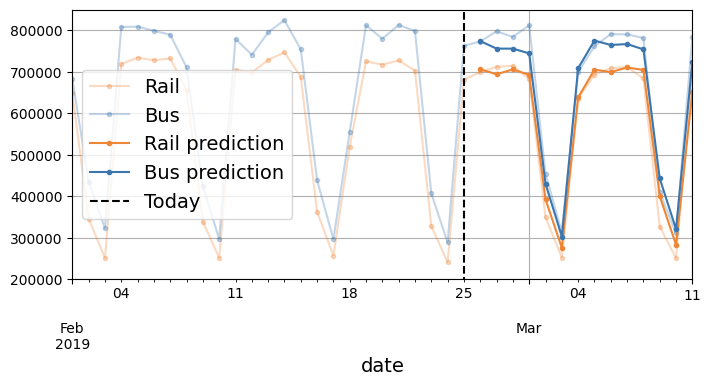

In [91]:
Y_pred_rail_s = pd.Series(Y_pred[0].cpu() * 1e6,
                          index=pd.date_range("2019-02-26", "2019-03-11"))
Y_pred_bus_s = pd.Series(Y_pred[1].cpu() * 1e6,
                         index=pd.date_range("2019-02-26", "2019-03-11"))
fig, ax = plt.subplots(figsize=(8, 3.5))
df["2019-02-01":"2019-03-11"]["rail"].plot(label="Rail", marker=".", ax=ax,
                                           color="#ef8636", alpha=0.3)
df["2019-02-01":"2019-03-11"]["bus"].plot(label="Bus", marker=".", ax=ax,
                                          color="#3b76af", alpha=0.3)
Y_pred_rail_s.plot(grid=True, marker=".", ax=ax, color="#ef8636",
                   label="Rail prediction")
Y_pred_bus_s.plot(grid=True, marker=".", ax=ax, color="#3b76af",
                  label="Bus prediction")
ax.vlines("2019-02-25", 0, 1e6, color="k", linestyle="--", label="Today")
ax.set_ylim([200_000, 850_000])
plt.legend(loc="center left")
plt.show()

This looks reasonably good, but of course you could train for longer, and perhaps do some hyperparameter tuning now (e.g., using Optuna).

## Exercise 10 — Generating Bach Chorales

### Step 1.
_Download the Bach chorales dataset from https://homl.info/bach and unzip it. It is composed of 382 chorales composed by Johann Sebastian Bach. Each chorale is 100 to 640 time steps long, and each time step contains 4 integers, where each integer corresponds to a note's index on a piano (except for the value 0, which means that no note is played)._

In [92]:
from pathlib import Path
import tarfile
import urllib.request

def download_bach_chorales():
    bach_chorales_dir = Path("datasets/jsb_chorales")
    if not bach_chorales_dir.exists():
        tarball_path = Path("datasets/jsb_chorales.tgz")
        if not tarball_path.exists():
            Path("datasets").mkdir(parents=True, exist_ok=True)
            print("Downloading...", end="")
            urllib.request.urlretrieve("https://homl.info/bach", tarball_path)
            print("Done.")
        with tarfile.open(tarball_path) as housing_tarball:
            print("Decompressing...", end="")
            housing_tarball.extractall(path="datasets", filter="data")
            print("Done.")
    return bach_chorales_dir

bach_chorales_dir = download_bach_chorales()

Downloading...Done.
Decompressing...Done.


The `bach_chorales` directory contains one directory for the training set, one for the validation set, and one for the test set. Each of these directories contains one CSV file per chorale. And each CSV file looks like this:

In [93]:
print(Path(bach_chorales_dir / "train" / "chorale_000.csv").read_text()[:84] + "...")

note0,note1,note2,note3
74,70,65,58
74,70,65,58
74,70,65,58
74,70,65,58
75,70,58,55
...


All the chorales fit in RAM so let's load them now:

In [94]:
import csv

def load_chorales(bach_chorales_dir):
    chorales = {"train": [], "valid": [], "test": []}
    for subset, chorale_list in chorales.items():
        for chorale_path in sorted((bach_chorales_dir / subset).glob("*.csv")):
            with chorale_path.open() as f:
                reader = csv.reader(f)
                next(reader)  # skip header row
                chorale = [[int(note) for note in row] for row in reader]
                chorale_list.append(torch.tensor(chorale))
    return chorales

chorales = load_chorales(bach_chorales_dir)

In [95]:
chorales["train"][0][:5]

tensor([[74, 70, 65, 58],
        [74, 70, 65, 58],
        [74, 70, 65, 58],
        [74, 70, 65, 58],
        [75, 70, 58, 55]])

Notes range from 36 (C2 = C on octave 2) to 81 (A5 = A on octave 5), plus 0 for silence.

Let's write a few functions to listen to these chorales (you don't need to understand the details here, and in fact there are certainly simpler ways to do this, for example using MIDI players, but I just wanted to have a bit of fun writing a synthesizer; see [this notebook](https://colab.research.google.com/github/ageron/jupyter-synth/blob/main/jupyter-synth.ipynb) for more details):

In [96]:
from IPython.display import Audio

def notes_to_frequencies(notes):
    # Frequency doubles when you go up one octave; there are 12 semi-tones
    # per octave; Note A on octave 4 is 440 Hz, and it is note number 69.
    return 2 ** ((notes - 69) / 12) * 440

def frequencies_to_samples(frequencies, tempo, sample_rate):
    note_duration = 60 / tempo # the tempo is measured in beats per minutes
    # To reduce click sound at every beat, we round the frequencies to try to
    # get the amplitude close to zero at the end of each note.
    frequencies = (note_duration * frequencies).round() / note_duration
    n_samples = int(note_duration * sample_rate)
    time = torch.linspace(0, note_duration, n_samples)
    sine_waves = torch.sin(2 * torch.pi * frequencies.reshape(-1, 1) * time)
    # Removing all notes with frequencies ≤ 9 Hz (includes note 0 = silence)
    sine_waves *= (frequencies > 9.).reshape(-1, 1)
    return sine_waves.reshape(-1)

def chords_to_samples(chords, tempo, sample_rate):
    freqs = notes_to_frequencies(chords)
    freqs = torch.cat([freqs, freqs[-1:]], dim=0) # make last note a bit longer
    merged = torch.stack([frequencies_to_samples(melody, tempo, sample_rate)
                          for melody in freqs.T]).mean(dim=0)
    n_fade_out_samples = sample_rate * 60 // tempo # fade out last note
    fade_out = torch.linspace(1., 0., n_fade_out_samples)**2
    merged[-n_fade_out_samples:] *= fade_out
    return merged

def play_chords(chords, tempo=160, amplitude=0.1, sample_rate=44100):
    samples = amplitude * chords_to_samples(chords, tempo, sample_rate)
    return display(Audio(samples, rate=sample_rate))

In [ ]:
for index in range(3):
    play_chords(chorales["train"][index])

Divine! 😇

In order to be able to generate new chorales, we will build an autoregressive model: one that can predict the next chord given previous chords. If we naively try to predict the next chord in one shot, predicting all 4 notes at once, we run the risk of getting notes that don't go very well together (believe me, I tried). It's much better and simpler to predict one note at a time. So we will need to preprocess every chorale, turning each chord into an arpegio (i.e., a sequence of notes rather than notes played simultaneuously). So each chorale will be a long sequence of notes (rather than chords), and we can just train a model that can predict the next note given all the previous notes. We will use a sequence-to-sequence approach, where we feed a window to the neural net, and it tries to predict that same window shifted one time step into the future.

For example, given the two chords [75, 70, 60, 55] and [77, 69, 62, 50], we can concatenate them into a sequence of notes [75, 70, 60, 55, 77, 69, 62, 50] and train the model to predict the shifted-by-one sequence [70, 60, 55, 77, 69, 62, 50, 74] (assuming the correct next note is 74).

However, we will do a bit more preprocessing to help the model:

1. We will prepend each chorale with a start-of-sequence (sos) token. This will give us something to feed the model if we want to generate a new chorale entirely from scratch. Let's encode this sos token as note #1.
2. Each note other than 0 (silence) and 1 (sos) will be shifted down from 36–81 to 2–47. So we will have 48 classes in total.
3. Notes will be one-hot encoded. Fancier options are possible (e.g., using trainable embeddings, see Chapter 14) but we'll keep things as simple as possible, and 48 different classes is still a manageable number.
4. We will add three more inputs to let the model know where each note lives within the chorale:

    * The note index within each chord (0 to 3)
    * The chord index modulo 4. This is likely to be most useful when the time signature is 4/4, which is generally the case. Note that the number of chords in every chorale is always a multiple of 4.
    * A progress percentage within each chorale: this will let us control the length of each generated chorale, and hopefully help the model know when to prepare for a nice finale.

So let's create a Bach dataset containing preprocessed windows and their corresponding targets.

In [98]:
def preprocess_note_indices(note_indices, length=None):
    notes_one_hot = F.one_hot(note_indices, num_classes=48).to(torch.float32)
    if length is None:
        length = len(note_indices)

    idx = torch.arange(len(note_indices), dtype=torch.float32,
                       device=note_indices.device).view(-1, 1) - 1
    return torch.cat([
        notes_one_hot,
        idx % 4,
        idx % 16 // 4,
        idx / (length - 1)
    ], dim=-1)

class BachDataset(torch.utils.data.Dataset):
    def __init__(self, chorales, window_length):
        self.chorales = chorales
        self.windows = []
        sos = torch.tensor([1])
        for chorale in chorales:
            notes = chorale.view(-1)
            note_indices = torch.cat([sos, F.relu(notes - 34)])
            X = preprocess_note_indices(note_indices)
            for index in range(len(notes) - window_length):
                self.windows.append((
                    X[index : index + window_length],
                    note_indices[index + 1 : index + window_length + 1]
                ))

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, index):
        return self.windows[index]

window_length = 128
train_set = BachDataset(chorales["train"], window_length)
valid_set = BachDataset(chorales["valid"], window_length)
test_set = BachDataset(chorales["test"], window_length)

Let's look at the start of the first window:

In [99]:
X, y = train_set[0]
X.shape, y.shape

(torch.Size([128, 51]), torch.Size([128]))

In [100]:
X.round(decimals=2)

tensor([[0.0000, 1.0000, 0.0000,  ..., 3.0000, 3.0000, -0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 3.0000, 0.1600],
        [0.0000, 0.0000, 0.0000,  ..., 1.0000, 3.0000, 0.1600],
        [0.0000, 0.0000, 0.0000,  ..., 2.0000, 3.0000, 0.1600]])

The first 48 features are the one-hot encoded note indices:

In [101]:
X[:, :48].argmax(dim=1)

tensor([ 1, 40, 36, 31, 24, 40, 36, 31, 24, 40, 36, 31, 24, 40, 36, 31, 24, 41,
        36, 24, 21, 41, 36, 24, 21, 41, 36, 26, 21, 41, 36, 26, 21, 43, 35, 28,
        16, 43, 35, 28, 16, 43, 35, 28, 16, 43, 35, 28, 16, 43, 36, 28, 21, 43,
        36, 28, 21, 43, 35, 28, 21, 43, 35, 28, 21, 41, 33, 29, 14, 41, 33, 29,
        14, 41, 35, 29, 14, 41, 35, 29, 14, 40, 36, 31, 12, 40, 36, 31, 12, 40,
        36, 31, 12, 40, 36, 31, 12, 38, 35, 31, 19, 38, 35, 31, 19, 38, 35, 31,
        19, 38, 35, 31, 19, 38, 35, 31, 19, 38, 35, 31, 19, 38, 35, 31, 19, 38,
        35, 31])

In [102]:
y

tensor([40, 36, 31, 24, 40, 36, 31, 24, 40, 36, 31, 24, 40, 36, 31, 24, 41, 36,
        24, 21, 41, 36, 24, 21, 41, 36, 26, 21, 41, 36, 26, 21, 43, 35, 28, 16,
        43, 35, 28, 16, 43, 35, 28, 16, 43, 35, 28, 16, 43, 36, 28, 21, 43, 36,
        28, 21, 43, 35, 28, 21, 43, 35, 28, 21, 41, 33, 29, 14, 41, 33, 29, 14,
        41, 35, 29, 14, 41, 35, 29, 14, 40, 36, 31, 12, 40, 36, 31, 12, 40, 36,
        31, 12, 40, 36, 31, 12, 38, 35, 31, 19, 38, 35, 31, 19, 38, 35, 31, 19,
        38, 35, 31, 19, 38, 35, 31, 19, 38, 35, 31, 19, 38, 35, 31, 19, 38, 35,
        31, 19])

Now let's build the data loaders:

In [103]:
torch.manual_seed(42)
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)

### Step 2.
_Train a model—recurrent, convolutional, or both—that can predict the next time step (four notes), given a sequence of time steps from a chorale._

We will use a small WaveNet-like neural network, composed of a stack of four `CausalConv1D` layers with doubling dilation rates. We will intersperse these layers with `BatchNormalization` layers for better convergence. Then one `LSTM` layer to try to capture long-term patterns. And finally a `Linear` layer to produce the final note logits. The model's output will have a shape of `[batch_size, 48, window_size]`.

In [104]:
class BachModel(nn.Module):
    def __init__(self, n_inputs=51, conv_dim=32, lstm_dim=64, n_notes=48):
        super().__init__()
        conv_layers = []
        for idx in range(4):
            conv_layers += [
                CausalConv1d(n_inputs, conv_dim, kernel_size=2, dilation=2**idx),
                nn.ReLU(),
                nn.BatchNorm1d(conv_dim),
            ]
            n_inputs = conv_dim

        self.conv_stack = nn.Sequential(*conv_layers)
        self.lstm = nn.LSTM(input_size=conv_dim, hidden_size=lstm_dim, batch_first=True)
        self.output = nn.Linear(lstm_dim, n_notes)

    def forward(self, X):
        Z = X.transpose(1, 2)
        Z = self.conv_stack(Z)
        Z = Z.transpose(1, 2)
        Z, _ = self.lstm(Z)
        Z = self.output(Z)
        return Z.transpose(1, 2)

torch.manual_seed(42)
bach_model = BachModel().to(device)

In [105]:
torch.manual_seed(42)
optimizer = torch.optim.NAdam(bach_model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=48).to(device)
history = train(bach_model, optimizer, criterion, accuracy, train_loader,
                valid_loader, n_epochs=5)

Epoch 1/5, train loss: 1.1154, train metric: 0.7213, valid metric: 0.8167
Epoch 2/5, train loss: 0.5759, train metric: 0.8341, valid metric: 0.8269
Epoch 3/5, train loss: 0.5259, train metric: 0.8438, valid metric: 0.8290
Epoch 4/5, train loss: 0.4980, train metric: 0.8501, valid metric: 0.8307
Epoch 5/5, train loss: 0.4780, train metric: 0.8546, valid metric: 0.8319


I have not done much hyperparameter search, so feel free to iterate on this model now and try to optimize it. For example, you could try removing the `LSTM` layer and replacing it with `Conv1D` layers. You could also play with the number of layers, the learning rate, the optimizer, and so on. Once you're satisfied with the performance of the model on the validation set, you can save it and evaluate it one last time on the test set:

In [106]:
evaluate_tm(bach_model, test_loader, accuracy)

tensor(0.8254, device='cuda:0')

**Note:** There's no real need for a test set in this exercise, since we will perform the final evaluation by just listening to the music produced by the model. So if you want, you can add the test set to the train set, and train the model again, hopefully getting a slightly better model.

### Step 3.
_Use this model to generate Bach-like music, one note at a time: you can do this by giving the model the start of a chorale and asking it to predict the next time step, then appending these time steps to the input sequence and asking the model for the next note, and so on. Also make sure to check out [Google's Coconet model](https://homl.info/coconet), which was used for a nice Google doodle about Bach._

Now let's write a function that will generate a new chorale. We will give it a few seed chords, it will convert them to arpegios (i.e., one note at a time, which is the format expected by the model), and use the model to predict the next note, then the next, and so on. In the end, it will group the notes 4 by 4 to create chords again, and return the resulting chorale.

In [107]:
def generate_chorale(model, seed_chords, num_chords):
    target_length = num_chords * 4 + 1
    notes = seed_chords.to(device).view(-1)
    sos = torch.tensor([1], dtype=torch.long, device=device)
    note_indices = torch.cat([sos, F.relu(notes - 34)])
    while len(note_indices) < target_length:
        X = preprocess_note_indices(note_indices, target_length)
        with torch.no_grad():
            new_note_logits = model(X.unsqueeze(0))

        new_note_index = new_note_logits[0, :, -1].argmax(keepdim=True)
        note_indices = torch.cat([note_indices, new_note_index])
        print(f"\r{len(note_indices) / target_length:.1%}", end="")

    notes = note_indices.where(note_indices < 2, note_indices + 34)
    return notes[1:].reshape(-1, 4)

To test this function, we need some seed chords. Let's use the first 8 chords of one of the validation chorales:

In [108]:
seed_chords = chorales["valid"][1][:8]

We ready to generate our first chorale! Let's ask the function to generate 56 more chords, for a total of 64 chords, i.e., 16 bars (assuming 4 chords per bar, i.e., a 4/4 signature):

In [109]:
torch.manual_seed(42)
chorale = generate_chorale(bach_model, seed_chords, 64).cpu()

100.0%

In [ ]:
play_chords(chorale)

This approach has one major flaw: it is often too conservative. Indeed, the model will not take any risk, it will always choose the note with the highest score, and since repeating the previous notes generally sounds good enough, it's the least risky option, so the algorithm will tend to make very repetitive chorales. Plus, if you run the model multiple times, it will always generate the same melody.

So let's spice things up a bit! Instead of always picking the note with the highest score, we will pick the next note randomly, according to the predicted probabilities. For example, if the model predicts a C3 with 75% probability, and a G3 with a 25% probability, then we will pick one of these two notes randomly, with these probabilities. We will also add a `temperature` parameter that will control how "hot" (i.e., daring) we want the system to feel. A high temperature will bring the predicted probabilities closer together, reducing the probability of the likely notes and increasing the probability of the unlikely ones. Given the logits, we divide them by the temperature, then use the `F.softmax()` function to convert the scaled logits to probabilities, and we use the `F.multinomial()` function to sample the new note index using these probabilities.

In [111]:
def generate_chorale_v2(model, seed_chords, num_chords, temperature=1):
    target_length = num_chords * 4 + 1
    notes = seed_chords.to(device).view(-1)
    sos = torch.tensor([1], dtype=torch.long, device=device)
    note_indices = torch.cat([sos, F.relu(notes - 34)])
    while len(note_indices) < target_length:
        X = preprocess_note_indices(note_indices, target_length)
        with torch.no_grad():
            new_note_logits = model(X.unsqueeze(0))

        new_note_probas = F.softmax(new_note_logits[0, :, -1] / temperature, dim=0)
        new_note_index = torch.multinomial(new_note_probas, num_samples=1)
        note_indices = torch.cat([note_indices, new_note_index])
        print(f"\r{len(note_indices) / target_length:.1%}", end="")

    notes = note_indices.where(note_indices < 2, note_indices + 34)
    return notes[1:].reshape(-1, 4)

Let's generate 3 chorales using this new function: one cold, one medium, and one hot (feel free to experiment with other seeds, lengths and temperatures). You can run these cells over and over again until you generate a masterpiece!

**Please share your most beautiful generated chorale with me on LinkedIn, BlueSky, or Twitter, I would really appreciate it! :))**

In [1062]:
seed_chords = chorales["valid"][1][:8]
generated_chorales = {}
for temperature in (0.6, 1.0, 1.1):
    torch.manual_seed(42)
    print("Temperature:", temperature)
    chorale = generate_chorale_v2(bach_model, seed_chords, 52, temperature).cpu()
    generated_chorales[temperature] = chorale
    play_chords(chorale)

Temperature: 0.6
100.0%
Temperature: 1.0
100.0%
Temperature: 1.1
100.0%


Lastly, you can try a fun social experiment: send your friends a few of your favorite generated chorales, plus the real chorale, and ask them to guess which one is the real one! You can use the following function to save your A.I. masterpiece to MP3 using the :

In [113]:
import soundfile as sf

def save_chorale(filepath, chords, tempo=160, amplitude=0.1, sample_rate=44100):
    samples = amplitude * chords_to_samples(chords, tempo, sample_rate)
    sf.write(filepath, samples, sample_rate)

In [114]:
save_chorale("my_chorale.mp3", generated_chorales[0.6])

If you are running this notebook in Colab or Kaggle, you must download the generate file to your computer before the runtime is discarded.

## Exercise 11 — QuickDraw Challenge
Exercise: _Train a classification model for the [QuickDraw dataset](https://homl.info/quickdraw), which contains millions of sketches of various objects.:_
* _Start by downloading the simplified data for a few classes (e.g., _ant.ndjson_, _axe.ndjson_, and _bat.ndjson_).
* _Each NDJSON file contains one JSON object per line, which you can parse using Python's `json.loads()` function. This will give you a list of sketches, where each sketch is represented as a Python dictionary._
* _In each dictionary, the `"drawing"` entry contains a list of pen strokes. You can convert this list to a 3D float tensor where the dimensions are [_strokes_, _x coordinates_, _y coordinates_]._
* _Since an RNN takes a single sequence as input, you will need to concatenate all the strokes for each sketch into a single sequence._
* _It's best to add an extra feature to allow the RNN to know how far along each stroke it currently is (e.g., from 0 to 1). In other words, the model will receive a sequence where each time step has three features: the _x_ and _y_ coordinates of the pen, and the progress ratio along the current stroke._

## Exercise 12 — Audio Yes/No Classification
Exercise: _Create a dataset containing short audio recordings of you saying "yes" or "no", and train a binary classification RNN on it. For example, you could:_
* _Use an audio recording software such as Audacity to record yourself saying "yes" as many times as your patience allows, with short pauses between each word. Create a similar recording for the word "no". Try to cover the various ways you might realistically pronounce these words in real life._
* _Load each WAV file using the `torchaudio.load()` function from the TorchAudio library. This will return a tensor containing the audio, as well as an integer indicating the number of samples per second. The audio tensor has a shape of [_channels_, _samples_]: one channel for mono, two for stereo. Convert stereo to mono by averaging over the channel dimension._
* _Chop each recording into individual words by splitting at the silences. You can do this using the `torchaudio.transforms.Vad` transform (Voice Activity Detection)._
* _Since the sequences are so long, it's hard to directly train an RNN on them, so it helps to convert the audio to a spectrogram first. For this, you can use the `torchaudio.transforms.MelSpectrogram` transform, which is well suited for voice. The output is a dramatically shorter sequence, with many more channels._
* _Now try building and training a binary classification RNN on your yes/no dataset! Consider sharing your dataset and model with the world (e.g., via the Hugging Face Hub)._

